In [91]:
import requests
import pandas as pd
import time
from concurrent.futures import ThreadPoolExecutor

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# Функция для получения идентификаторов вакансий
def find_ids(job_titles, levels, area=2759, url='https://api.hh.ru/vacancies/'):
    ids = []

    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = []
        for title in job_titles:
            for level in levels:
                params = {'text': f'{title} {level}', 'area': area, 'per_page': 100}
                futures.append(executor.submit(fetch_ids, url, params, ids))

        for future in futures:
            future.result()  # Ожидаем завершения всех задач

    return ids

def fetch_ids(url, params, ids):
    try:
        time.sleep(1)  # Задержка перед запросом
        response = requests.get(url, headers=headers, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()

        for item in data['items']:
            if len(ids) < 200:
                ids.append(item.get('id'))
    except requests.exceptions.RequestException as e:
        print(f'Error: {e}')

# Функция для заполнения данных вакансий
def fill_row(m):
    salary = m.get('salary', {})
    return {
        'id': m.get('id'),
        'vacancy_name': m.get('name'),
        'level': m.get('experience', {}).get('name', None),  # Используем уровень опыта
        'city': m.get('area', {}).get('name', None),  # Город
#         'salary_from': salary.get('from', None),  # Зарплата от
#         'salary_to': salary.get('to', None),  # Зарплата до
#         'currency': salary.get('currency', None)  # Валюта зарплаты
    }

# Функция для создания итоговой таблицы
def create_df(ids, url):
    vacancies = []

    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = []
        for id in ids:
            futures.append(executor.submit(fetch_vacancy_data, url, id, vacancies))

        for future in futures:
            future.result()  # Ожидаем завершения всех задач

    return pd.DataFrame(vacancies)

def fetch_vacancy_data(url, id, vacancies):
    try:
        response = requests.get(f'{url}{id}', timeout=10)  # Установка таймаута
        response.raise_for_status()  # Проверка на ошибки
        data = response.json()
        vacancies.append(fill_row(data))
    except requests.exceptions.RequestException as e:
        print(f'Error: {e}')  # Обработка ошибки

# Основные параметры
url = 'https://api.hh.ru/vacancies/'
levels = ['Junior', 'Middle', 'Senior']
area = 2759

# Получаем ID вакансий для каждой специальности
ids_data_analyst = find_ids(['Data Analyst'], levels, area=area)
ids_data_science = find_ids(['Data Science'], levels, area=area)
ids_data_engineer = find_ids(['Data Engineer'], levels, area=area)

# Создаем итоговые таблицы с вакансиями
df_1 = create_df(ids_data_analyst, url)
df_2 = create_df(ids_data_science, url)
df_3 = create_df(ids_data_engineer, url)



Error: HTTPSConnectionPool(host='api.hh.ru', port=443): Max retries exceeded with url: /vacancies/?text=Data+Science+Middle&area=2759&per_page=100 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000024EB7C35150>, 'Connection to api.hh.ru timed out. (connect timeout=10)'))
Error: HTTPSConnectionPool(host='api.hh.ru', port=443): Max retries exceeded with url: /vacancies/105529422 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000024EB7C36AA0>, 'Connection to api.hh.ru timed out. (connect timeout=10)'))
Error: HTTPSConnectionPool(host='api.hh.ru', port=443): Max retries exceeded with url: /vacancies/107689004 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x0000024EB6F8C6D0>, 'Connection to api.hh.ru timed out. (connect timeout=10)'))
Error: HTTPSConnectionPool(host='api.hh.ru', port=443): Max retries exceeded with url: /vacancies/108060661 (Caused by ConnectTimeoutError(<urllib3.connection.HTTP

In [92]:
df_1['vacancy_name'] = 'Data Analyst'
df_2['vacancy_name'] = 'Data Science'
df_3['vacancy_name'] = 'Data Engineer'
res = pd.concat([df_1, df_2, df_3], ignore_index=True)
res['level'] = res['level'].replace('Более 6 лет', 'Senior')
res['level'] = res['level'].replace('От 3 до 6 лет', 'Middle')
res['level'] = res['level'].replace('От 1 года до 3 лет', 'Junior')
res['level'] = res['level'].replace('Нет опыта', 'Junior')
grouped_df = res.groupby(['vacancy_name', 'level']).size().reset_index(name='count')
grouped_df

,vacancy_name,level,count
0,Data Analyst,Junior,5
1,Data Analyst,Middle,11
2,Data Analyst,Senior,3
3,Data Engineer,Junior,5
4,Data Engineer,Middle,18
5,Data Engineer,Senior,3
6,Data Science,Junior,1
7,Data Science,Middle,5
8,Data Science,Senior,2


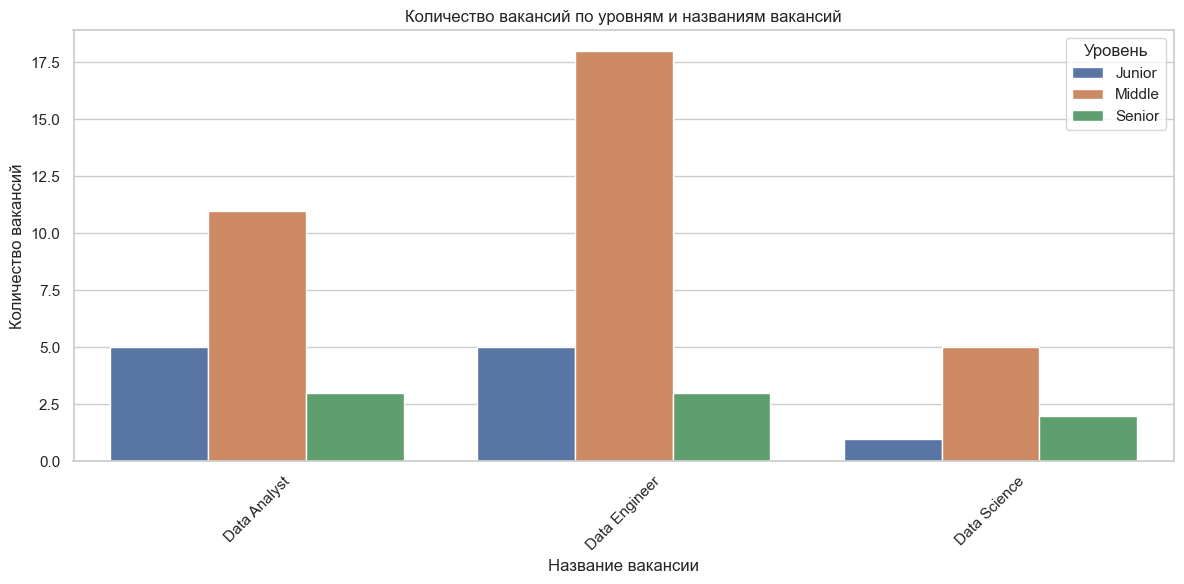

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Устанавливаем стиль графиков
sns.set(style='whitegrid')

# Создаем столбчатую диаграмму
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_df, x='vacancy_name', y='count', hue='level')
plt.title('Количество вакансий по уровням и названиям вакансий')
plt.xlabel('Название вакансии')
plt.ylabel('Количество вакансий')
plt.legend(title='Уровень')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()